In [ ]:
import os
import sys
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
import traceback
from utils import map_images_to_classes

In [ ]:
# make csv file for AST Feature Extractor (audio segments(10xsong)and valence classes)

# create function that splits data train-test-validate based on df(csv) and extracts equal parts of each class---) new dfs

# create function that does the same thing but like a dataloader --) nothing new created, only associations

In [2]:
dfg = pd.read_csv('../data/processed/1000dataset_valence_cluster.csv')


In [3]:
#count unique values in column 'valence_cluster'
valence_cluster = dfg['valence_cluster'].value_counts()
print(valence_cluster)

valence_cluster
high      386
medium    314
low       300
Name: count, dtype: int64


In [5]:
dfg = pd.read_csv('../data/processed/1000dataset_valence_cluster.csv')
spec_df_danceability = map_images_to_classes('../data/processed/1000dataset_5/specs', dfg, 'track_id', 'valence_cluster')

In [6]:
# label encode the class
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
spec_df_danceability['class'] = labelencoder.fit_transform(spec_df_danceability['class'])

In [8]:
#spec_df_danceability.head(6)
# save it to csv
spec_df_danceability.to_csv('../data/processed/L1000dataset_5seg_valence.csv', index=False)

Keep only audio in 'audio' folder

In [6]:
# run move_json_files function
#move_json_files()

Transoform audio to spectograms

In [57]:
import random
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
import gc
import traceback


def mp3_to_melspectrogram(mp3_file, audio_output_folder, spec_output_folder, trim_seconds=30,
                          include_legend=False, nmels=512, segment_duration=5, save_audio_segments=True,
                          num_segments=5):
    """
    Converts an MP3 file to mel spectrograms and optionally saves the audio segments.

    Parameters:
        mp3_file (str): Path to the MP3 file.
        audio_output_folder (str): Folder to save the audio segments.
        spec_output_folder (str): Folder to save the spectrogram images.
        trim_seconds (int): Number of seconds to trim from both ends of the audio.
        include_legend (bool): Whether to include legends and axes in the spectrogram plots.
        nmels (int): Number of mel bands to generate in the spectrogram.
        segment_duration (int): Duration of each segment in seconds. If None, processes the entire audio.
        save_audio_segments (bool): Whether to save the corresponding audio segments.
        num_segments (int or None): Number of segments to save. If None, saves all segments.
    """
    # Ensure both output folders exist
    os.makedirs(audio_output_folder, exist_ok=True)
    os.makedirs(spec_output_folder, exist_ok=True)

    try:
        print(f"Loading file: {mp3_file}")

        # Load the MP3 file using PyDub
        audio = AudioSegment.from_file(mp3_file)
        total_duration_ms = len(audio)  # Duration in milliseconds
        total_duration = total_duration_ms / 1000.0  # Convert to seconds
        print(f"File {mp3_file}, Total Duration: {total_duration:.2f} seconds")

        # Check if the file is long enough to trim
        if total_duration <= 2 * trim_seconds:
            print(f"File {mp3_file} is too short to trim {trim_seconds} seconds from both ends. Skipping.")
            return

        # Trim the first and last trim_seconds
        start_trim = trim_seconds * 1000  # Convert to milliseconds
        end_trim = total_duration_ms - trim_seconds * 1000
        audio_trimmed = audio[start_trim:end_trim]

        print(f"Trimmed audio length (ms): {len(audio_trimmed)}")

        # Calculate segment length in samples if segment_duration is specified
        sr = audio_trimmed.frame_rate
        samples_per_segment = int(segment_duration * sr) if segment_duration else len(audio_trimmed.get_array_of_samples())

        # Convert to NumPy array
        y = np.array(audio_trimmed.get_array_of_samples()).astype(np.float32)

        # Convert stereo to mono
        if audio_trimmed.channels == 2:
            y = y.reshape((-1, 2)).mean(axis=1)

        print(f"Sample rate: {sr}, Audio shape after conversion: {y.shape}")

        # Determine the total number of segments
        total_segments = len(y) // samples_per_segment

        # Select random segments if num_segments is specified
        if num_segments is not None and num_segments < total_segments:
            selected_indices = sorted(random.sample(range(total_segments), num_segments))
        else:
            selected_indices = list(range(total_segments))

        print(f"Total segments: {total_segments}, Selected segments: {len(selected_indices)}")

        # Process each selected segment
        for segment_count, idx in enumerate(selected_indices, start=1):
            start_sample = idx * samples_per_segment
            segment = y[start_sample:start_sample + samples_per_segment]

            # Generate the mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=nmels)
            D = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Plot and save the mel spectrogram
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(D, sr=sr, x_axis='time' if include_legend else None,
                                     y_axis='mel' if include_legend else None, cmap='inferno')

            if include_legend:
                plt.colorbar(format='%+2.0f dB')  # Add color bar if include_legend is True
                plt.title(f'Mel Spectrogram of {os.path.basename(mp3_file)} - Segment {segment_count}')  # Add title
            else:
                plt.axis('off')  # Turn off axes if include_legend is False
                plt.gca().set_position([0, 0, 1, 1])  # Remove any padding/margins

            # Save the spectrogram image
            output_image_path = os.path.join(
                spec_output_folder, f"{os.path.splitext(os.path.basename(mp3_file))[0]}_segment_{segment_count}.png"
            )
            plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0 if not include_legend else 0.1)
            plt.close()

            print(f"Spectrogram saved to {output_image_path}")

            # Save the corresponding audio segment if required
            if save_audio_segments:
                audio_segment = audio_trimmed[start_sample // sr * 1000:(start_sample + samples_per_segment) // sr * 1000]
                audio_segment_path = os.path.join(
                    audio_output_folder, f"{os.path.splitext(os.path.basename(mp3_file))[0]}_segment_{segment_count}.mp3"
                )
                audio_segment.export(audio_segment_path, format="mp3")
                print(f"Audio segment saved to {audio_segment_path}")

        # Explicitly release memory
        del audio, audio_trimmed, y, segment
        gc.collect()

    except Exception as e:
        print(f"Error processing {mp3_file}: {e}")
        traceback.print_exc()  # Print detailed error traceback
        
def process_all_mp3_in_folder(folder_path, audio_output_folder, spec_output_folder):
    # Ensure the output folders exist
    os.makedirs(audio_output_folder, exist_ok=True)
    os.makedirs(spec_output_folder, exist_ok=True)

    # Loop through all MP3 files in the folder
    for file in os.listdir(folder_path):
        if file.endswith(".mp3"):
            mp3_file = os.path.join(folder_path, file)

            # Check if the first spectrogram segment exists
            first_segment_path = os.path.join(
                spec_output_folder, f"{os.path.splitext(file)[0]}_segment_1.png"
            )
            if os.path.exists(first_segment_path):
                print(f"Skipping {mp3_file}, spectrogram already exists.")
                continue

            print(f"Processing file: {mp3_file}")
            mp3_to_melspectrogram(mp3_file, audio_output_folder, spec_output_folder)


In [ ]:
process_all_mp3_in_folder("../data/raw/1000dataset", "../data/processed/1000dataset_5/audio", "../data/processed/1000dataset_5/audio_specs")

In [ ]:
# Example usage for processing multiple MP3 files
folder_path = "../data/raw/1000dataset"  # Folder containing MP3 files
#output_folder = "../data/raw/1000_mel_spectrograms"  # Folder to save spectrogram images
output_folder = "../data/processed/1000_melspec_5seg_png"  # Folder to save segmented spectrogram images
process_all_mp3_in_folder(folder_path, output_folder)


legend and segment parameters

# Transform text to jsonl form


In [ ]:
# {"file_name" : "3odrUVQ9tvRpkC9II2oWzx_segment_5.png", "additional_feature": "Ellie Goulding electro"}
# So if the str before the first underscore is the same to the row track_id column, then add text to the additional feature column

{'file_name': '3odrUVQ9tvRpkC9II2oWzx_segment_5.png',
 'additional_feature': 'Ellie Goulding electro'}

SEGMENT SPECTOGRAM


Transform audio and segment spectograms


Transform spectogram to audio

In [ ]:
import numpy as np
import librosa
import librosa.display
from pydub import AudioSegment

# Function to convert spectrogram to audio and save it as MP3
def spectrogram_to_mp3(spec, sr, filename="output.mp3"):
    # Step 1: Invert the spectrogram to a time-domain audio signal
    # If the spectrogram is in dB, first convert back to amplitude
    if np.max(spec) < 0:  # Checking if it's in dB scale
        spec = librosa.db_to_amplitude(spec)
    
    # If the spectrogram is a magnitude spectrogram, use librosa's inverse STFT
    audio_signal = librosa.istft(spec)
    
    # Step 2: Save the audio signal as a WAV file
    librosa.output.write_wav("temp.wav", audio_signal, sr)
    
    # Step 3: Convert WAV to MP3 using pydub
    sound = AudioSegment.from_wav("temp.wav")
    sound.export(filename, format="mp3")
    
    print(f"Saved MP3 as {filename}")

# Example usage
if __name__ == "__main__":
    # Load an example audio file to create a spectrogram
    y, sr = librosa.load(librosa.example('trumpet'))
    
    # Generate a spectrogram from the audio signal
    spec = librosa.stft(y)
    spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
    
    # Convert the spectrogram back to MP3
    spectrogram_to_mp3(spec_db, sr, filename="output.mp3")


CHECK FROM SPECTOGRAM TO MP3

In [18]:
image_path = "raw/spectrograms/0A0RBBTrgfq9eClnw6ZXT7.png"


In [ ]:
import numpy as np
import librosa
from PIL import Image
from pydub import AudioSegment
import soundfile as sf  # For saving audio files

def image_to_spectrogram(image_path):
    """
    Convert a spectrogram image to a numerical array representing the spectrogram.
    Assumes the spectrogram is grayscale, where pixel intensity represents dB values.
    """
    # Load the image
    img = Image.open(image_path).convert("L")  # Convert to grayscale ('L' mode)
    
    # Convert image to numpy array
    img_array = np.array(img)
    
    # Normalize the image to [0, 1] range (0 is minimum, 255 is maximum)
    img_array = img_array / 255.0

    # Convert the image intensities to dB scale (assuming they represent dB)
    # Rescale from [0, 1] to [-80 dB, 0 dB], as typical dB range for spectrograms is -80 to 0
    img_db = img_array * -80
    
    return img_db

def spectrogram_to_audio(spectrogram_db, sr=22050, hop_length=512):
    """
    Invert a dB-scaled spectrogram back to an audio waveform.
    """
    # Convert dB to amplitude
    spectrogram_amplitude = librosa.db_to_amplitude(spectrogram_db)
    
    # Perform the inverse Short-Time Fourier Transform (ISTFT) to recover the audio signal
    audio_signal = librosa.griffinlim(spectrogram_amplitude, hop_length=hop_length)
    
    return audio_signal

def save_as_mp3(audio_signal, sr, filename="output.mp3"):
    """
    Save the audio signal as an MP3 file using pydub.
    """
    # Save the audio signal as a temporary WAV file using soundfile
    sf.write("temp.wav", audio_signal, sr)  # Use soundfile to save as WAV
    
    # Convert the WAV file to MP3 using pydub
    sound = AudioSegment.from_wav("temp.wav")
    sound.export(filename, format="mp3")
    print(f"Saved MP3 as {filename}")

# Example usage
if __name__ == "__main__":
    # Path to the spectrogram image (PNG)
    image_path = "raw/spectrograms/0A0RBBTrgfq9eClnw6ZXT7.png"
    
    # Step 1: Convert the image to a spectrogram
    spectrogram_db = image_to_spectrogram(image_path)
    
    # Step 2: Convert the spectrogram to an audio signal
    audio_signal = spectrogram_to_audio(spectrogram_db, sr=22050)
    
    # Step 3: Save the audio signal as MP3
    save_as_mp3(audio_signal, sr=22050, filename="output.mp3")


In [1]:
from utils import process_spectrogram_folder

folder='spectrograms_generated'
process_spectrogram_folder(folder)

FINAL TRANSFORMATION FROM AUDIO TO SPECTROGRAM BASED ON RIFFUSION NEEDS


In [63]:
import os
import gc
import glob
import numpy as np
import torch
import torchaudio
import librosa
from PIL import Image

#####################################
# Riffusion Parameters (unchanged)
#####################################
image_width = 512
sample_rate = 44100  # [Hz]
clip_duration_ms = 5000  # [ms]

bins_per_image = 512
n_mels = 512

# FFT parameters
window_duration_ms = 100  # [ms]
padded_duration_ms = 400  # [ms]
step_size_ms = 10   # [ms]

# Derived parameters
num_samples = int(image_width / float(bins_per_image) * clip_duration_ms) * sample_rate
n_fft = int(padded_duration_ms / 1000.0 * sample_rate)
hop_length = int(step_size_ms / 1000.0 * sample_rate)
win_length = int(window_duration_ms / 1000.0 * sample_rate)

#####################################
# Existing Unchanged Functions
#####################################

def spectrogram_from_waveform(
    waveform: np.ndarray,
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    mel_scale: bool = True,
    n_mels: int = 512,
) -> np.ndarray:
    """
    Convert a waveform (time-domain) signal into either a magnitude STFT
    or a magnitude Mel spectrogram (depending on mel_scale).
    """
    spectrogram_func = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        power=None,
        hop_length=hop_length,
        win_length=win_length,
    )

    waveform_tensor = torch.from_numpy(waveform.astype(np.float32)).reshape(1, -1)
    Sxx_complex = spectrogram_func(waveform_tensor).numpy()[0]
    Sxx_mag = np.abs(Sxx_complex)

    if mel_scale:
        mel_scaler = torchaudio.transforms.MelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            f_min=0,
            f_max=10000,
            n_stft=n_fft // 2 + 1,
            norm=None,
            mel_scale="htk",
        )
        Sxx_mag = mel_scaler(torch.from_numpy(Sxx_mag)).numpy()

    return Sxx_mag


def image_from_spectrogram(spectrogram: np.ndarray, max_volume: float = 50, power_for_image: float = 0.25) -> Image.Image:
    """
    Convert a 2D spectrogram array into a PIL image, applying dynamic
    range compression, inversion, flipping, and conversion to RGB.
    """
    data = np.power(spectrogram, power_for_image)
    data = data * 255 / max_volume
    data = 255 - data
    image = Image.fromarray(data.astype(np.uint8))
    image = image.transpose(Image.FLIP_TOP_BOTTOM)
    image = image.convert("RGB")
    return image

#####################################
# Modified Function: Now with num_segments
#####################################

def process_single_wav_file_5sec_segments(
    input_wav_path: str,
    out_audio_folder: str,
    out_spectrogram_folder: str,
    num_segments: int = 2  # <-- New parameter: how many 5-second segments to create
):
    """
    1) Load .wav at 44100 Hz (global sample_rate).
    2) Trim the first 30s and the last 30s.
    3) Split into *5-second* segments, discarding leftover < 5s,
       and stopping once we've created 'num_segments' segments.
    4) Generate spectrogram (via spectrogram_from_waveform) 
       and image (via image_from_spectrogram).
    5) Save each segment's .wav in out_audio_folder,
       and each spectrogram .png in out_spectrogram_folder.
    """

    # Ensure output directories exist
    os.makedirs(out_audio_folder, exist_ok=True)
    os.makedirs(out_spectrogram_folder, exist_ok=True)

    # 1. Load the .wav at the global Riffusion sample_rate (44100)
    audio_data, sr = librosa.load(input_wav_path, sr=sample_rate)

    total_length_sec = len(audio_data) / float(sr)
    print(f"\nProcessing file: {os.path.basename(input_wav_path)}")
    print(f"Original audio length: {total_length_sec:.2f} seconds")

    # 2. Trim 30s from start, 30s from end
    trim_start_sec = 30.0
    trim_end_sec = 30.0
    start_sample = int(trim_start_sec * sr)
    end_sample = len(audio_data) - int(trim_end_sec * sr)

    if start_sample >= end_sample:
        print("WARNING: Trimming exceeds audio length. Skipping this file.")
        return

    audio_data = audio_data[start_sample:end_sample]
    trimmed_length_sec = len(audio_data) / float(sr)
    print(f"Trimmed audio length: {trimmed_length_sec:.2f} seconds")

    # 3. Build up to 'num_segments' chunks of exactly 5 seconds each
    segment_length_sec = 5.0
    segment_length_samples = int(segment_length_sec * sr)
    segments = []

    idx = 0
    while len(segments) < num_segments and (idx + segment_length_samples <= len(audio_data)):
        segment = audio_data[idx : idx + segment_length_samples]
        # If for some reason the chunk is > 5s, trim it
        if len(segment) > segment_length_samples:
            segment = segment[:segment_length_samples]
        segments.append(segment)
        idx += segment_length_samples

    print(f"Number of 5-second segments used: {len(segments)} (limit was {num_segments})")

    # 4. For each segment: create spectrogram, save .wav, save .png
    base_name = os.path.splitext(os.path.basename(input_wav_path))[0]
    for i, segment in enumerate(segments, start=1):
        seg_sec = len(segment) / float(sr)
        print(f"  Segment {i}: {seg_sec:.2f} seconds")

        # Create spectrogram with original function (unchanged)
        spec = spectrogram_from_waveform(segment, sample_rate=sample_rate)

        # Dynamically compute max_volume for image
        current_max = np.max(spec)
        if current_max < 1e-10:
            current_max = 1.0
        power_for_image = 0.25
        max_volume = np.ceil(np.power(current_max, power_for_image))

        # Create image with original function (unchanged)
        img = image_from_spectrogram(spec, max_volume=50, power_for_image=power_for_image)

        # Save segment audio as .wav
        audio_output_path = os.path.join(out_audio_folder, f"{base_name}_segment_{i}.wav")
        segment_tensor = torch.from_numpy(segment).unsqueeze(0)  # shape (1, samples)
        torchaudio.save(audio_output_path, segment_tensor, sr)

        # Save spectrogram as .png
        image_output_path = os.path.join(out_spectrogram_folder, f"{base_name}_segment_{i}.png")
        img.save(image_output_path)

        print(f"    -> Saved segment audio to      {audio_output_path}")
        print(f"    -> Saved spectrogram image to  {image_output_path}")

        # Optional: clear memory
        gc.collect()

#####################################
# Main Folder-Processing Function (unchanged)
#####################################

def process_all_wav_in_folder(
    input_folder: str,
    output_audio_folder: str,
    output_spectrogram_folder: str
):
    """
    Processes all .wav files in 'input_folder' (non-recursive).
    For each file, outputs 5-second segments (up to a limit set
    in process_single_wav_file_5sec_segments) as .wav in 'output_audio_folder',
    and .png in 'output_spectrogram_folder'.
    """
    wav_files = glob.glob(os.path.join(input_folder, "*.wav"))
    if not wav_files:
        print(f"No .wav files found in {input_folder}")
        return

    print(f"Found {len(wav_files)} wav file(s) in {input_folder}\n")

    os.makedirs(output_audio_folder, exist_ok=True)
    os.makedirs(output_spectrogram_folder, exist_ok=True)

    for wav_path in wav_files:
        process_single_wav_file_5sec_segments(
            input_wav_path=wav_path,
            out_audio_folder=output_audio_folder,
            out_spectrogram_folder=output_spectrogram_folder,
            # Optionally, pass num_segments=... if you want a custom number 
            # (default is 10 in the function definition).
        )

    print("\nAll .wav files have been processed!")



In [65]:
import os
import gc
import glob
import numpy as np
import torch
import torchaudio
import librosa
import random
from PIL import Image

#####################################
# Riffusion Parameters (UNCHANGED)
#####################################
image_width = 512
sample_rate = 44100  # [Hz]
clip_duration_ms = 5000  # [ms]

bins_per_image = 512
n_mels = 512

# FFT parameters
window_duration_ms = 100  # [ms]
padded_duration_ms = 400  # [ms]
step_size_ms = 10   # [ms]

# Derived parameters
num_samples = int(image_width / float(bins_per_image) * clip_duration_ms) * sample_rate
n_fft = int(padded_duration_ms / 1000.0 * sample_rate)
hop_length = int(step_size_ms / 1000.0 * sample_rate)
win_length = int(window_duration_ms / 1000.0 * sample_rate)

#####################################
# Unchanged Utility Functions
#####################################

def spectrogram_from_waveform(
    waveform: np.ndarray,
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    mel_scale: bool = True,
    n_mels: int = 512,
) -> np.ndarray:
    """
    Convert a waveform (time-domain) signal into either a magnitude STFT
    or a magnitude Mel spectrogram (depending on mel_scale).
    """
    spectrogram_func = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        power=None,  # Return complex values
        hop_length=hop_length,
        win_length=win_length,
    )

    waveform_tensor = torch.from_numpy(waveform.astype(np.float32)).reshape(1, -1)
    Sxx_complex = spectrogram_func(waveform_tensor).numpy()[0]
    Sxx_mag = np.abs(Sxx_complex)

    if mel_scale:
        mel_scaler = torchaudio.transforms.MelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            f_min=0,
            f_max=10000,
            n_stft=n_fft // 2 + 1,
            norm=None,
            mel_scale="htk",
        )
        Sxx_mag = mel_scaler(torch.from_numpy(Sxx_mag)).numpy()

    return Sxx_mag


def image_from_spectrogram(
    spectrogram: np.ndarray,
    max_volume: float = 50,
    power_for_image: float = 0.25
) -> Image.Image:
    """
    Convert a 2D spectrogram array into a PIL image, applying dynamic
    range compression, inversion, flipping, and conversion to RGB.
    """
    data = np.power(spectrogram, power_for_image)
    data = data * 255 / max_volume
    data = 255 - data
    image = Image.fromarray(data.astype(np.uint8))
    image = image.transpose(Image.FLIP_TOP_BOTTOM)
    image = image.convert("RGB")
    return image


#####################################
# Single File Processing (RANDOM BLOCK SAMPLING)
#####################################

def process_single_wav_file_5sec_segments(
    input_wav_path: str,
    out_audio_folder: str,
    out_spectrogram_folder: str,
    num_segments: int = 10  # how many random 5-second segments you want at most
):
    """
    1) Load .wav at 44100 Hz (global sample_rate).
    2) Trim the first 30s and the last 30s.
    3) Enumerate all *non-overlapping* 5-second blocks (in order), 
       then randomly pick up to 'num_segments' of them (no overlap, guaranteed).
    4) Generate spectrogram (via spectrogram_from_waveform)
       and image (via image_from_spectrogram).
    5) Save each segment's .wav in out_audio_folder,
       and each spectrogram .png in out_spectrogram_folder.
    """

    # Ensure output directories exist
    os.makedirs(out_audio_folder, exist_ok=True)
    os.makedirs(out_spectrogram_folder, exist_ok=True)

    # 1. Load .wav at global sample_rate = 44100
    audio_data, sr = librosa.load(input_wav_path, sr=sample_rate)

    total_length_sec = len(audio_data) / float(sr)
    print(f"\nProcessing file: {os.path.basename(input_wav_path)}")
    print(f"Original audio length: {total_length_sec:.2f} seconds")

    # 2. Trim 30s from start, 30s from end
    trim_start_sec = 30.0
    trim_end_sec = 30.0
    start_sample = int(trim_start_sec * sr)
    end_sample = len(audio_data) - int(trim_end_sec * sr)

    if start_sample >= end_sample:
        print("WARNING: Trimming exceeds audio length. Skipping this file.")
        return

    audio_data = audio_data[start_sample:end_sample]
    trimmed_length_sec = len(audio_data) / float(sr)
    print(f"Trimmed audio length: {trimmed_length_sec:.2f} seconds")

    # 3a. Compute how many 5-second blocks are possible
    segment_length_sec = 5.0
    segment_length_samples = int(segment_length_sec * sr)
    total_samples = len(audio_data)

    # If there's not even 5 seconds, we can't form a single segment
    if total_samples < segment_length_samples:
        print("Not enough audio left for even one 5-second segment.")
        return

    # 3b. Build the list of all possible 5-second blocks in series
    #     e.g. block 1: [0 : 5s], block 2: [5s : 10s], ...
    all_blocks = []
    idx = 0
    block_count = 0
    while idx + segment_length_samples <= total_samples:
        block_count += 1
        all_blocks.append((idx, idx + segment_length_samples))
        idx += segment_length_samples

    # 3c. Randomly choose up to num_segments blocks from these
    # If the user wants more segments than exist, they'll just get them all
    chosen_blocks_count = min(num_segments, len(all_blocks))
    chosen_blocks = random.sample(all_blocks, chosen_blocks_count)

    print(f"Total possible 5-second blocks: {len(all_blocks)}")
    print(f"Number of blocks randomly chosen: {len(chosen_blocks)} (limit was {num_segments})")

    # Optionally, if you want to process them in chronological order:
    # chosen_blocks.sort(key=lambda x: x[0])

    # 4. Process each chosen block
    base_name = os.path.splitext(os.path.basename(input_wav_path))[0]

    for i, (seg_start, seg_end) in enumerate(chosen_blocks, start=1):
        seg_samples = audio_data[seg_start:seg_end]
        seg_sec = len(seg_samples) / float(sr)
        print(f"  Segment {i}: Start={seg_start}, End={seg_end}, Duration={seg_sec:.2f} seconds")

        # Generate spectrogram with original function (unchanged)
        spec = spectrogram_from_waveform(seg_samples, sample_rate=sr)

        # Dynamically compute max_volume for image
        current_max = np.max(spec)
        if current_max < 1e-10:
            current_max = 1.0
        power_for_image = 0.25
        max_volume = np.ceil(np.power(current_max, power_for_image))

        # Create image with original function (unchanged)
        img = image_from_spectrogram(spec, max_volume=max_volume, power_for_image=power_for_image)

        # Save segment audio as .wav
        audio_output_path = os.path.join(out_audio_folder, f"{base_name}_segment_{i}.wav")
        seg_tensor = torch.from_numpy(seg_samples).unsqueeze(0)  # shape (1, samples)
        torchaudio.save(audio_output_path, seg_tensor, sr)

        # Save spectrogram as .png
        image_output_path = os.path.join(out_spectrogram_folder, f"{base_name}_segment_{i}.png")
        img.save(image_output_path)

        print(f"    -> Saved segment audio to      {audio_output_path}")
        print(f"    -> Saved spectrogram image to  {image_output_path}")

        # Optional: clear memory
        gc.collect()


#####################################
# Main Folder-Processing Function
#####################################

def process_all_wav_in_folder(
    input_folder: str,
    output_audio_folder: str,
    output_spectrogram_folder: str
):
    """
    Processes all .wav files in 'input_folder' (non-recursive).
    For each file, enumerates all contiguous 5-second blocks in the
    trimmed audio, then randomly picks 'num_segments' among them
    (ensuring no overlap).
    Saves .wav segments in 'output_audio_folder',
    and .png in 'output_spectrogram_folder'.
    """
    wav_files = glob.glob(os.path.join(input_folder, "*.wav"))
    if not wav_files:
        print(f"No .wav files found in {input_folder}")
        return

    print(f"Found {len(wav_files)} WAV file(s) in {input_folder}\n")

    os.makedirs(output_audio_folder, exist_ok=True)
    os.makedirs(output_spectrogram_folder, exist_ok=True)

    for wav_path in wav_files:
        # If you want a custom number of random segments, pass num_segments=... here
        process_single_wav_file_5sec_segments(
            input_wav_path=wav_path,
            out_audio_folder=output_audio_folder,
            out_spectrogram_folder=output_spectrogram_folder,
            num_segments=10  # or any other integer
        )

    print("\nAll .wav files have been processed!")

In [66]:
process_all_wav_in_folder("C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/test", 
                          "C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/testaa",
                          "C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/tests")

Found 1 WAV file(s) in C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/test


Processing file: 0ahmam4Hqa4hZD1QbUop13.wav
Original audio length: 151.67 seconds
Trimmed audio length: 91.67 seconds
Total possible 5-second blocks: 18
Number of blocks randomly chosen: 10 (limit was 10)
  Segment 1: Start=3307500, End=3528000, Duration=5.00 seconds
    -> Saved segment audio to      C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/testaa\0ahmam4Hqa4hZD1QbUop13_segment_1.wav
    -> Saved spectrogram image to  C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/tests\0ahmam4Hqa4hZD1QbUop13_segment_1.png
  Segment 2: Start=441000, End=661500, Duration=5.00 seconds
    -> Saved segment audio to      C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/testaa\0ahmam4Hqa4hZD1QbUop13_segment_2.wav
    -> Saved spectrogram image to  C:/Users/spbsp/OneDrive - 

In [ ]:
audio_path = "C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/testa/0ahmam4Hqa4hZD1QbUop13_segment_2.mp3"
sound = AudioSegment.from_file(audio_path)
sound.export("C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/testa/0ahmam4Hqa4hZD1QbUop13_segment_2.wav", format="wav")

In [ ]:
#Folder
audio_path = "C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/testa/0ahmam4Hqa4hZD1QbUop13_segment_2.mp3"
sound = AudioSegment.from_file(audio_path)
sound.export("C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/testa/0ahmam4Hqa4hZD1QbUop13_segment_2.wav", format="wav")

In [1]:

import os
import gc
import random
import numpy as np
import torch
from PIL import Image

from pydub import AudioSegment
import torchaudio


# Riffusion Parameters
image_width = 512
sample_rate = 44100  # [Hz]
clip_duration_ms = 5000  # [ms]

bins_per_image = 512
n_mels = 512

# FFT parameters
window_duration_ms = 100  # [ms]
padded_duration_ms = 400  # [ms]
step_size_ms = 10  # [ms]

# Derived parameters
num_samples = int(image_width / float(bins_per_image) * clip_duration_ms) * sample_rate
n_fft = int(padded_duration_ms / 1000.0 * sample_rate)
hop_length = int(step_size_ms / 1000.0 * sample_rate)
win_length = int(window_duration_ms / 1000.0 * sample_rate)



def spectrogram_from_waveform(
    waveform: np.ndarray,
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    mel_scale: bool = True,
    n_mels: int = 512,
) -> np.ndarray:

    spectrogram_func = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        power=None,
        hop_length=hop_length,
        win_length=win_length,
    )

    waveform_tensor = torch.from_numpy(waveform.astype(np.float32)).reshape(1, -1)
    Sxx_complex = spectrogram_func(waveform_tensor).numpy()[0]

    Sxx_mag = np.abs(Sxx_complex)

    if mel_scale:
        mel_scaler = torchaudio.transforms.MelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            f_min=0,
            f_max=10000,
            n_stft=n_fft // 2 + 1,
            norm=None,
            mel_scale="htk",
        )

        Sxx_mag = mel_scaler(torch.from_numpy(Sxx_mag)).numpy()

    return Sxx_mag



def image_from_spectrogram(spectrogram: np.ndarray, max_volume: float = 50, power_for_image: float = 0.25) -> Image.Image:
    data = np.power(spectrogram, power_for_image)
    data = data * 255 / max_volume
    data = 255 - data
    image = Image.fromarray(data.astype(np.uint8))
    image = image.transpose(Image.FLIP_TOP_BOTTOM)
    image = image.convert("RGB")

    return image

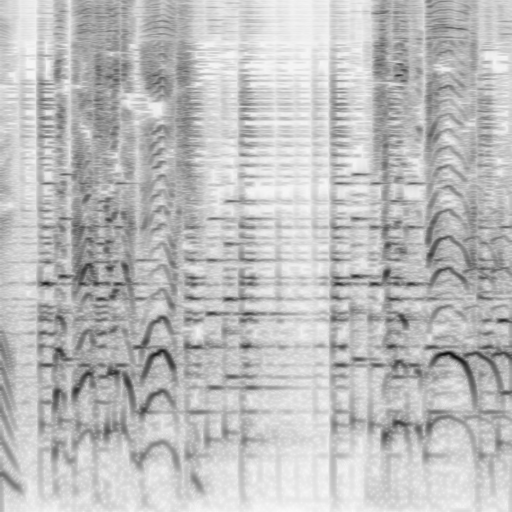

In [30]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

audio_path = "C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/test/0ahmam4Hqa4hZD1QbUop13.wav"
audio_cust_whole, sample_rate = librosa.load(audio_path, sr=44100)
# take just first 5 seconds of audio
audio_cust_data = audio_cust_whole[225500:451000]

# Transfer audio to spectrogram image
spec_cust_data = spectrogram_from_waveform(audio_cust_data)
power_for_image = 0.25
max_volume = np.ceil(np.power(np.max(spec_cust_data),power_for_image)) # max volume depends on our audio recoding conditions
image_cust = image_from_spectrogram(spec_cust_data, max_volume=max_volume, power_for_image=power_for_image)
image_cust

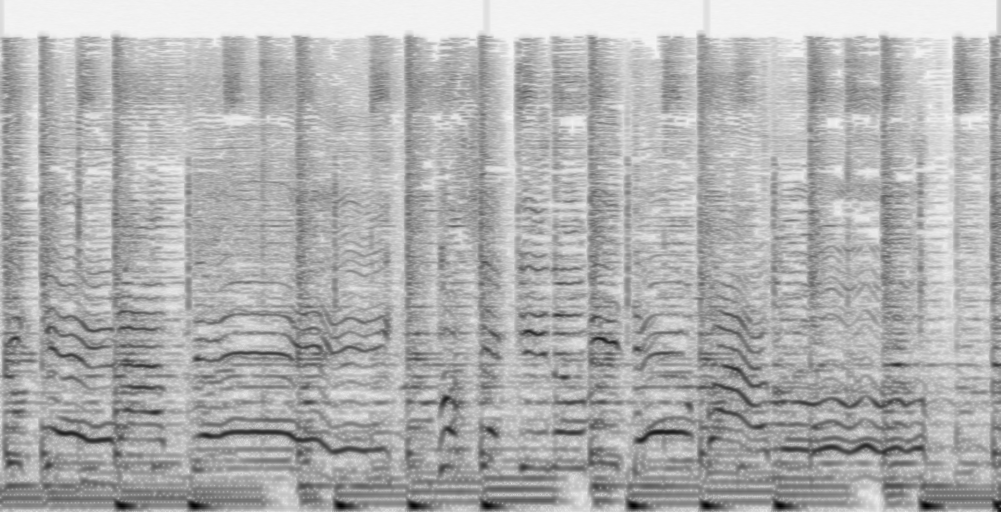

In [6]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment

audio_path = "C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/testa/0ahmam4Hqa4hZD1QbUop13_segment_2.mp3"
audio=AudioSegment.from_file(audio_path)
sr = audio.frame_rate
audio_cust_data = np.array(audio.get_array_of_samples()).astype(np.float32)


# Transfer audio to spectrogram image
spec_cust_data = spectrogram_from_waveform(audio_cust_data)
power_for_image = 0.25
max_volume = np.ceil(np.power(np.max(spec_cust_data),power_for_image)) # max volume depends on our audio recoding conditions
image_cust = image_from_spectrogram(spec_cust_data, max_volume=max_volume, power_for_image=power_for_image)
image_cust

In [14]:
import os
from pathlib import Path
from subprocess import run, CalledProcessError
from tqdm import tqdm  # For progress bar

# ===== CONFIG =====
input_folder = "C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/1000dataset"  # Path to folder with MP3 files
output_folder = os.path.join(input_folder, "wav_files")  # Output subfolder
# ==================

# Create output folder if it doesn't exist
Path(output_folder).mkdir(parents=True, exist_ok=True)

# Get all MP3 files in input folder
mp3_files = [f for f in os.listdir(input_folder) if f.lower().endswith('.mp3')]

print(f"Found {len(mp3_files)} MP3 files. Converting to WAV...")

# Convert each file using FFmpeg
for filename in tqdm(mp3_files):
    try:
        # Build paths
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, f"{Path(filename).stem}.wav")
        
        # FFmpeg command for conversion
        command = [
            "ffmpeg", 
            "-y",               # Overwrite output without asking
            "-i", input_path,   # Input file
            "-ar", "44100",     # Set sample rate (optional, 44.1kHz is standard)
            "-ac", "2",         # Set number of audio channels (optional, 2 for stereo)
            output_path         # Output file
        ]
        
        # Run FFmpeg
        run(command, check=True)

    except CalledProcessError as e:
        print(f"\nFailed to convert {filename}: {str(e)}")
    except Exception as e:
        print(f"\nUnexpected error for {filename}: {str(e)}")

print(f"\nConversion complete! WAV files saved to: {output_folder}")


Found 1000 MP3 files. Converting to WAV...


100%|██████████| 1000/1000 [04:54<00:00,  3.39it/s]


Conversion complete! WAV files saved to: C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/1000dataset\wav_files


In [ ]:
process_all_mp3_in_folder("C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/test", 
                          "C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/testaudio",
                          "C:/Users/spbsp/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DiffAudio/data/raw/testspectrograms")